In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import gamma as Gamma
from scipy.stats import invgamma
from math import sqrt
from numpy.linalg import inv, det, slogdet
from statsmodels.sandbox.distributions.multivariate import multivariate_t_rvs
import time

from statsmodels.graphics.gofplots import qqplot

import seaborn as sns

#note: if arch python library does not import,use the hard coded values obtained from MLE, below in the code

'''
import arch
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal, SkewStudent, StudentsT,GeneralizedError
'''

from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.ndimage.interpolation import shift

import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [3]:
df = pd.read_csv('INTC.csv')
df.index = df['Date']
df = df.drop(columns=['Open', 'High', 'Low','Close','Volume'])
df = df.rename(columns={'Adj Close': 'price'})
df['returns'] = np.log(df['price']).diff()
dates = df.Date[1:] #because we have daily returns started from day 1 (not 0)
display(df.head())

,Date,price,returns
Date,,,
2009-06-08,2009-06-08,11.656049,NaN
2009-06-09,2009-06-09,12.022135,0.030924
2009-06-10,2009-06-10,12.051419,0.002433
2009-06-11,2009-06-11,11.970881,-0.006705
2009-06-12,2009-06-12,11.941595,-0.002449


In [4]:
am = ConstantMean(df['returns'][1:])
am.volatility = GARCH(1, 0, 1)
am.distribution = StudentsT()

res = am.fit(disp = 'off', update_freq = 7)
#display(res.summary())

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [5]:
GARCH_param = pd.DataFrame({'Asset' : 'Stock', 'omega' : [res.params['omega']],
                            'alpha' : [res.params['alpha[1]']],
                            'beta' : [res.params['beta[1]']],
                            'nu' : [res.params['nu']]                            
                           })

GARCH_param.set_index('Asset', inplace = True)

display(GARCH_param)
res.summary()

,omega,alpha,beta,nu
Asset,,,,
Stock,0.0,0.985204,0.014677,49.515688


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                      returns   R-squared:                      -1.143
Mean Model:                   Constant Mean   Adj. R-squared:                 -1.143
Vol Model:                            GARCH   Log-Likelihood:                1042.94
Distribution:      Standardized Student's t   AIC:                          -2075.87
Method:                  Maximum Likelihood   BIC:                          -2046.80
                                              No. Observations:                 2474
Date:                      Tue, Jun 18 2019   Df Residuals:                     2469
Time:                              09:21:58   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu            -0.0158  1.324e-03    -11.919  9.425e-33 [-1.837e-02,-1.318e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0000  2.383e-07      0.000      1.000 [-4.670e-07,4.670e-07]
alpha[1]       0.9852  9.320e-02     10.571  4.075e-26      [  0.803,  1.168]
beta[1]        0.0147  3.598e-03      4.079  4.531e-05  [7.624e-03,2.173e-02]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu            49.5157      4.049     12.228  2.198e-34 [ 41.579, 57.452]
========================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate successful convergence. The message was
Inequality constraints incompatible. See convergence_flag.
"""

In [6]:
GARCH_param

,omega,alpha,beta,nu
Asset,,,,
Stock,0.0,0.985204,0.014677,49.515688


We will consider the GARCH(1,1) with Student-t innovations model of the log-returns process \{$y_t$, $t\in \mathcal{Z}$\}, for $t = 1, \dots, T$:

$$    y_t = \epsilon_t \cdot h_t^{1/2} $$

where $\epsilon_t$ is a sequence of $i.i.d.$ variables $\sim$ ${\mathcal{t}}(\nu)$, 

$$ h_t = \omega + \alpha \cdot y^2_{t-1} + \beta \cdot h_{t-1}$$

for $\omega > 0$; $\alpha,\beta \geq 0$; ${\mathcal{t}}(\nu)$ denotes the Students-t distribution with $\nu$ degrees of freedom. The restriction on the GARCH parameters $\omega$, $\alpha$, $\beta$ guarantee the conditional variance's positivity.

The term $(\alpha + \beta)$ is the degree of persistence in the autocorrelation of the squares which controls the intensity of the clustering in the variance process. With a value close to one, past shocks and past variances will have a longer impact on the future conditional variance.


In [11]:
GARCH_param['alpha'][0]+GARCH_param['beta'][0]

0.9998804004375589

Best practices:

Work with logs for every function for numerical stability.
We divise into many functions for easier unit testing.

To ensure conditional variance and likelihood to be well-behaved, we need to enforce the following constraints:
$\omega>0 ; \alpha \geq 0; \beta  \geq  0; \omega + \alpha < 1$.

We chose normal priors over $\omega$, $\alpha$, $\beta$: 

$$p(\omega)\propto \phi_{\mathcal{N}}(\omega | \mu_0, \Sigma_0) \cdot \mathbb{1}_{\omega>0}$$

$$p(\alpha)\propto \phi_{\mathcal{N}}(\alpha | \mu_0, \Sigma_0) \cdot \mathbb{1}_{\alpha \geq 0}$$

$$p(\beta)\propto \phi_{\mathcal{N}}(\beta | \mu_0, \Sigma_0) \cdot \mathbb{1}_{\beta  \geq  0}$$

In [12]:
#we use truncated normal priors on the GARCH parameters alpha ; beta ; omega
def log_gaussian_prior_omega(mu_0=0, sigma_0=0.0005):
    ans = lambda omega: -0.5 * np.log(2 * np.pi)\
                        - np.log( sigma_0 )\
                        - 0.5 * (omega - mu_0)**2 / sigma_0**2 \
                        if omega>0 else 0
    return ans

def log_gaussian_prior_alpha(mu_0=0.05, sigma_0=0.05):
    ans = lambda alpha: -0.5 * np.log(2 * np.pi)\
                        - np.log( sigma_0 )\
                        - 0.5 * (alpha - mu_0)**2 / sigma_0**2\
                        if alpha>0 else 0
    return ans

def log_gaussian_prior_beta(mu_0=1, sigma_0=0.2):
    ans = lambda beta: -0.5 * np.log(2 * np.pi)\
                       - np.log( sigma_0 )\
                       - 0.5 * (beta - mu_0)**2 / sigma_0**2\
                       if beta>0 else 0
    return ans

We assume prior independence between the parameters, i.e.: 
$$p(\theta) = p(\omega)p(\alpha)p(\beta)$$

In [13]:
def log_joint_prior():
    log_prior_omega    = log_gaussian_prior_omega()
    log_prior_alpha    = log_gaussian_prior_alpha()
    log_prior_beta     = log_gaussian_prior_beta()
    ans = lambda omega, alpha, beta: log_prior_omega(omega) + log_prior_alpha(alpha) + log_prior_beta(beta)
    return ans

In [14]:
#this aims to replace y_t values equal to 0 by the lowest positive value in the serie  
logret = df['returns'].tolist()
logret[0] = 0
logret=np.array(logret)

lowest_values = pd.DataFrame(columns=['lowest values'])
for ret in logret:
    if (np.abs(ret) < 0.0002) and (ret != 0):
        lowest_values=lowest_values.append({'lowest values':ret}, ignore_index=True)

lowest_value_in_yt = np.min(np.abs(lowest_values['lowest values']))

for i,ret in enumerate(logret):
    if ret==0:
        logret[i]=lowest_value_in_yt

We fill in the vector $$h_t = \omega + \alpha y_{t-1}^2 + \beta h _{t-1}$$

In [15]:
def h(omega, alpha ,beta): 
    logret = df['returns'].tolist()
    logret[0] = lowest_value_in_yt #arbitrary value, otherwise we would have h[0]=0 with which we would try to divide y_t by later on
    logret = np.array(logret)
    T = df.shape[0]
    
    #initialize vector
    h = np.zeros(T)

    for t in range(T-1):
        h[t+1]= omega + alpha * logret[t]**2 + beta * h[t]
    h = h[1:]
    return h

In [16]:

logret = df['returns'].tolist()
logret = np.array(logret[1:])

#set of priors from MLE

omega = GARCH_param['omega'][0]
alpha = GARCH_param['alpha'][0]
beta = GARCH_param['beta'][0]
nu = GARCH_param['nu'][0]

#NOTE: if ARCH has incompatibilities, work with the hardcoded values below (INTC stock)
#omega = 0
#alpha =  0.05
#beta = 0.93
'''GARCH_param = pd.DataFrame(columns=['omega',
                                    'alpha',
                                    'beta'
                                   ],index = ['values'])'''
#GARCH_param['omega'][0] = 0
#GARCH_param['alpha'][0] = 0.05
#GARCH_param['beta'][0] = 0.93

print('0')

0


In [17]:
GARCH_param

,omega,alpha,beta,nu
Asset,,,,
Stock,0.0,0.985204,0.014677,49.515688


The likelihood function applied to our GARCH(1,1) with student innovations yields:

$$ L(\theta|y) \propto \prod_{t=1}^{T} \dfrac {\Gamma(\dfrac{\nu+1}{2})} {\Gamma(\nu/2)\nu^{1/2}\pi^{1/2}h_t^{1/2}} \cdot \left[1+\dfrac{1}{\nu}\dfrac{y_t^2}{h_t} \right]^{-\dfrac{\nu+1}{2}}   $$


$$ log(L(\theta|y)) \propto  T\left[ log(\Gamma(\dfrac{\nu+1}{2}) - log(\Gamma(\dfrac{\nu}{2}))-\dfrac{1}{2}log(\nu)-\dfrac{1}{2}log(\pi)\right] - \sum_{t=1}^T \dfrac{1}{2}log(h_t)+(\dfrac{\nu+1}{2})\left[1+\dfrac{1}{\nu}\dfrac{y_t^2}{h_t} \right]        $$

We define the log posterior as:

$$log(p(\theta | y)) \propto log(L(\theta|y))\cdot log(p(\theta)) \$$

In [19]:
def log_posterior(y,omega,alpha,beta):
    log_prior = log_joint_prior()
    ans = log_prior(omega,alpha,beta)
    
    T=df.shape[0]
    nu=GARCH_param['nu'][0] #set arbitrarily the \nu_MLE as the student degree of freedom 
    
    ht = h(omega,alpha,beta)
    
    log_student_likelihood = T*( np.log( Gamma((nu+1)*0.5) )\
                                - np.log( Gamma(0.5*nu))\
                                - 0.5*np.log(nu)\
                                - 0.5*np.log(np.pi) )\
                                - 0.5*np.log(ht)\
                                - (0.5*(nu+1)) * (1 + (1/nu)*( (y**2)/ht ) ) 
                                                            
    ans += sum(log_student_likelihood)

    return ans
    

In [20]:
GARCH_param

,omega,alpha,beta,nu
Asset,,,,
Stock,0.0,0.985204,0.014677,49.515688


In [21]:
#we here create a dataframe which will contain all MH simulations we will computed, and their results
#we define the cell here to avoid emptying out the results if changing the theta_proposal or MH sampling function
all_simulations_so_far = pd.DataFrame(columns=['# batches', #number of batches of nsims to be run
                                                 'sims / batch', #number of simulations ran per batch of sims
                                                 'time_per_MH', #total time taken for the whole MH computation (k*nsims)
                                                 'scale', #scale (i.e. stepsize)
                                                 'array_stepsize', #stepsize affected to each var
                                                 'avg_omega / MH_sampling', #average value of omega over all batches
                                                 'avg_alpha / MH_sampling',
                                                 'avg_beta / MH_sampling',
                                                 'Skip_rate', #rate where the constraints are not respected
                                                 'U>R_rate', #rate where the uniform r.v. U > R
                                                 'A_rate', #acceptance rate U <= R
                                              ],index=range(1,1))

all_simulations_so_far.index.name = 'MH_sampling_id'

In [22]:
#if you want to retrieve your previous simulations, load the file

all_simulations_so_far = pd.read_csv('all_simulations_so_far.csv')
all_simulations_so_far = all_simulations_so_far.drop(columns=['Unnamed: 0'])
print('0')

0


In [23]:
all_simulations_so_far

,# batches,sims / batch,time_per_MH,scale,array_stepsize,avg_omega / MH_sampling,avg_alpha / MH_sampling,avg_beta / MH_sampling,Skip_rate,U>R_rate,A_rate
0,1,10000,0min 30s,1,[1.0e-09 4.8e-03 2.0e-05],0.000001,0.998738,0.017259,0.42490,0.47410,0.10100
1,1,10000,0min 32s,1,[1.0e-09 4.5e-03 2.0e-05],0.000001,0.998773,0.017355,0.41910,0.47230,0.10860
2,1,10000,0min 32s,1,[1.e-09 3.e-03 2.e-05],0.000001,0.998861,0.018919,0.40080,0.46130,0.13790
3,1,10000,0min 28s,1,[1.e-09 1.e-01 2.e-05],0.000000,0.996000,0.014806,0.48820,0.48910,0.02270
4,1,10000,0min 50s,1,[1.e-09 1.e-04 2.e-05],0.000001,0.996901,0.031057,0.06020,0.35890,0.58090
5,1,10000,0min 38s,1,[1.e-09 8.e-04 2.e-05],0.000001,0.998845,0.023973,0.29140,0.41210,0.29650
6,1,10000,0min 41s,1,[1.e-09 5.e-04 2.e-05],0.000001,0.998402,0.025189,0.23740,0.38560,0.37700
7,1,10000,0min 44s,1,[1.e-09 4.e-04 8.e-06],0.000001,0.997713,0.016890,0.21340,0.38520,0.40140
8,1,10000,0min 44s,1,[1.0e-09 4.5e-04 8.0e-06],0.000001,0.998125,0.017441,0.22060,0.39470,0.38470
9,1,10000,0min 45s,1,[1.0e-09 3.5e-04 8.0e-06],0.000001,0.998233,0.016980,0.20760,0.37300,0.41940


In [24]:
GARCH_param

,omega,alpha,beta,nu
Asset,,,,
Stock,0.0,0.985204,0.014677,49.515688


In [25]:
all_simulations_so_far.tail()

,# batches,sims / batch,time_per_MH,scale,array_stepsize,avg_omega / MH_sampling,avg_alpha / MH_sampling,avg_beta / MH_sampling,Skip_rate,U>R_rate,A_rate
10,1,10000,0min 51s,1,[1.e-09 2.e-04 8.e-06],0.000001,0.998295,0.018177,0.13910,0.36000,0.50090
11,1,100000,9min 44s,1,[1.e-09 2.e-04 8.e-06],0.000007,0.999223,0.043244,0.11369,0.17034,0.71597
12,1,100000,5min 7s,1,[1.0e-09 4.5e-03 8.0e-06],0.000002,0.999539,0.018807,0.46554,0.47966,0.05480
13,1,100000,7min 58s,1,[1.0e-09 4.5e-04 8.0e-06],0.000006,0.999340,0.038400,0.21650,0.25595,0.52755
14,1,10000,0min 31s,1,[1.0e-09 4.5e-03 8.0e-06],0.000001,0.998622,0.015303,0.42650,0.46920,0.10430


In [26]:
def theta_proposal(omega_i,alpha_i,beta_i, scale,omega_stepsize,alpha_stepsize,beta_stepsize):   

    theta_i = np.array([omega_i,alpha_i,beta_i])       
    dim = theta_i.shape[0]
  
    #since we only want to tune the scale (stepsize), choose flat priors on other hyperparameters of the model
    sigma = 1
    mu = 0
    
    eta = np.random.standard_t(df=5, size=dim)    
    
    #size of the eta_n function of the stepsize \lambda
    stepsize = np.diag(np.ones(dim))*scale
    
    array_stepsize = np.array([omega_stepsize,alpha_stepsize,beta_stepsize])
    
    stepsize[0][0] *= omega_stepsize #omega stepsize coefficient
    stepsize[1][1] *= alpha_stepsize #alpha stepsize coefficient
    stepsize[2][2] *= beta_stepsize #beta stepsize coefficient
    
    # @ sign yields the same result as np.dot() for this matrix shape
    theta = theta_i + stepsize@eta

    #Note that we will enforce the conditions to guarantee the constraints' satisfaction in the MH algorithm
    return theta,array_stepsize

In [27]:
def metropolis_hastings(nsims, nb_of_times_we_run_nsims, scale, data, stepsize_theta): 
    start = time. time()
    
    #consider MLE estimates as initial values
    omega_i = GARCH_param['omega'][0]
    alpha_i = GARCH_param['alpha'][0]
    beta_i = GARCH_param['beta'][0]
    
    #group them into theta_i
    theta_i = np.array([omega_i,alpha_i,beta_i])
    
    #array of all theta arrays
    all_thetas = np.array(theta_i)
    
    #temp value used if we have nb_of_times_we_run_nsims > 1
    theta_init = theta_i
    
    #initialiaze dataframe which will include all relevant specifications
    rates = pd.DataFrame(columns=['# simulations',
                                  'Time for 1 batch of sims',
                                  'Skip_rate',
                                  'U>R_rate',
                                  'A_rate'],
                        index=range(1,nb_of_times_we_run_nsims+1))
    rates.index.name = 'batch of nsims id'
    
    summary = pd.DataFrame(columns=['Total MH algo time',
                                    'Avg time per batch of sims (in s.)',
                                    'array_stepsize'
                                   ],
                           index=['values'])
    
    beta_step_sizes = pd.DataFrame(columns=['beta_stepsize_if_skipped',
                                   'beta_stepsize_if_U>R',
                                    'beta_stepsize_if_accepted'
                                   ],
                           index=['values'])
         
    #dataframe containing all_thetas (i.e. an array of arrays) in each cell
    all_thetas_of_all_thetas = pd.DataFrame(columns=['All thetas'], 
                    index=range(1,nb_of_times_we_run_nsims+1))
    
    print('********************** LAUNCHING SAMPLING PROCEDURE **********************')
    
    #if nb_of_times_we_run_nsims > 1: we launch the input value times nsims simulations, results are averaged
    for k in range(1,nb_of_times_we_run_nsims+1): 
    
        #initialize all counts and rates at each batch
        count = 0
        skip = 0
        skipping_rate=0
        next_iter = 0
        next_iter_rate = 0 
        acceptance_rate = 0
        all_thetas = theta_init #re-initiliaze the all_thetas array with the initial MLE values
        intra_sim_time_start = time. time()
    
        ######################## MH SAMPLER ########################
        for n in range(nsims):           

            #create theta_prop
            theta_prop,array_stepsize = theta_proposal(*theta_i,scale,*stepsize_theta)
                    
            #if constraints not satisfied, iterate 
            if not (theta_prop[0]>0 and theta_prop[1]>=0 and theta_prop[2] >=0 and (theta_prop[0]+theta_prop[1])<1):
                skip +=1
                continue #iterate to next simulation
        
            #implementing the acceptance decision within the MH algorithm eases unit testing
            f_theta_proposal_given_data = log_posterior(y,*theta_prop)             
            f_theta_i_given_data = log_posterior(y,*theta_i)

            log_ratio = f_theta_proposal_given_data - f_theta_i_given_data
            ratio = np.exp(log_ratio)           
            R = min(ratio,1)

            u = np.random.uniform(0, 1, 1)

            if u <= R:
                #if we do have u<= R: set the theta proposal as our new theta_i
                theta_i = theta_prop 
        
                #stack into the array of thetas
                all_thetas = np.vstack((all_thetas,theta_i)) 
                count += 1 
           
            else:
                #stack the theta_i (hence next sim will discard the current theta_prop)
                all_thetas = np.vstack((all_thetas,theta_i)) 
                next_iter += 1
                continue

        acceptance_rate = count/nsims
        skipping_rate = skip /nsims
        next_iter_rate = next_iter /nsims

        #record the thetas obtained from a batch, into a cell of all_thetas_of_all_thetas dataframe
        all_thetas_of_all_thetas['All thetas'][k]=all_thetas
        
        rates['# simulations'][k] = nsims
        rates['Skip_rate'][k] = skipping_rate
        rates['U>R_rate'][k] = next_iter_rate
        rates['A_rate'][k] = acceptance_rate
        
        intra_sim_time_end = time. time()
        rates['Time for 1 batch of sims'][k] = intra_sim_time_end - intra_sim_time_start
        print('Time taken for batch number ',
              k,' is: ',
              np.around(rates['Time for 1 batch of sims'][k],4))
        
    summary['Mean Skip_rate'] = rates['Skip_rate'].mean()
    summary['Mean U>R_rate'] = rates['U>R_rate'].mean() 
    summary['Mean A_rate'] = rates['A_rate'].mean()
    
    end = time. time()
    
    seconds = end - start
    minutes, seconds = divmod(seconds, 60)
    minutes = int(minutes)
    seconds = int(seconds)
    z = "%smin %ss" % (minutes,seconds)
    
    summary['Total MH algo time'] = z
    summary['Avg time per batch of sims (in s.)'] = (end - start)/nb_of_times_we_run_nsims
    summary['array_stepsize'][0] = array_stepsize

    #display(rates)
    display(summary)
    #print(rates.head(30).to_latex())
    #print(summary.head().to_latex())
    
    return all_thetas_of_all_thetas,rates,summary,z

In [28]:
GARCH_param

,omega,alpha,beta,nu
Asset,,,,
Stock,0.0,0.985204,0.014677,49.515688


In [157]:
#aim: having skipping_rate+next_iter_rate to be roughly equal to 0.5 since scale impacts both,
#hence aiming for an acceptance rate at 0.50 +/- 0.05 by the end of the simulation procedure

scale = 1

y=logret

nb_sims = 1
alpha_stepsize = 0.0000001
beta_stepsize = 0.0000001
omega_stepsize = 1e-09

theta_stepsize = np.array([omega_stepsize,alpha_stepsize,beta_stepsize])

all_thetas_of_all_thetas,rates,summary,z = metropolis_hastings(nsims=10000,
                                                                nb_of_times_we_run_nsims = nb_sims,
                                                                scale=scale,
                                                                data=logret,
                                                                stepsize_theta=theta_stepsize)

********************** LAUNCHING SAMPLING PROCEDURE **********************


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in exp


Time taken for batch number  1  is:  55.3759


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Total MH algo time,Avg time per batch of sims (in s.),array_stepsize,Mean Skip_rate,Mean U>R_rate,Mean A_rate
values,0min 55s,55.38384,"[1e-09, 1e-07, 1e-07]",0.0002,0.3406,0.6592


In [158]:
GARCH_param

,omega,alpha,beta,nu
Asset,,,,
Stock,0.0,0.985204,0.014677,49.515688


In [159]:
#compute the posterior mean
#the following cell computes relevant statistics to allow comparison between the different samplings
#and highlight the cost of the computation while varying from model and sampling method

posterior_mean_computations = pd.DataFrame(columns=['means per sim batch',
                                                    'median per sim batch',
                                                     'avg omega value',
                                                     'avg alpha value',
                                                     'avg beta value',
                                                     'median omega value',
                                                     'median alpha value',
                                                     'median beta value'
                                                   ],
                        index=range(1,all_thetas_of_all_thetas.shape[0]+1))

posterior_mean_computations.index.name = 'batch of nsims id'

posterior_mean_approximation = pd.DataFrame(columns=['avg omega / batches of sims',
                                                     'avg alpha / batches of sims',
                                                     'avg beta / batches of sims'],
                                                     index=['values'])
#used to average over all batches of simulations
for i in range(1,all_thetas_of_all_thetas.shape[0]+1):

    posterior_mean_computations['means per sim batch'][i] = np.around(np.mean(all_thetas_of_all_thetas['All thetas'][i], axis = 0),6)
    posterior_mean_computations['median per sim batch'][i] = np.around(np.median(all_thetas_of_all_thetas['All thetas'][i], axis = 0),6)
    
variable_list=['omega','alpha','beta']

for variable in range(len(variable_list)):
    for sim_id in range(1,posterior_mean_computations.shape[0]+1):
        
        #if we set a step_size too big, and a n_sims too low, 
        #we might get errors where a theta value would not be a tuple (i.e. a single value, of float type)
        #in which case, it is safer not to include these values and iterate forward
        
        #average
        if ( type (posterior_mean_computations['means per sim batch'][sim_id] ) != np.float64 ):
            posterior_mean_computations['avg '+variable_list[variable]+' value'][sim_id] = posterior_mean_computations['means per sim batch'][sim_id][variable]
        else:
            continue
            
        #median
        if ( type (posterior_mean_computations['means per sim batch'][sim_id] ) != np.float64 ):
            posterior_mean_computations['median '+variable_list[variable]+' value'][sim_id] = posterior_mean_computations['means per sim batch'][sim_id][variable]
        else:
            continue

            
#display(posterior_mean_computations)

for variable in range(len(variable_list)):
    for sim_id in range(1,posterior_mean_computations.shape[0]+1):
        posterior_mean_approximation['avg '+variable_list[variable]+' / batches of sims'] = posterior_mean_computations['avg '+variable_list[variable]+' value'].mean()

posterior_mean_approximation['nb_batches'] = posterior_mean_computations.shape[0]
posterior_mean_approximation['nb_sims_per_batch'] = rates['# simulations'][1]
    
#display(posterior_mean_approximation)

In [160]:
#append the relevant statistics to our dataframe of all MH sampling done

all_simulations_so_far = all_simulations_so_far.append({'# batches' : rates.shape[0],
                                                        'sims / batch' : rates['# simulations'][1],
                                                        'time_per_MH' : summary['Total MH algo time'][0],
                                                        'scale' : scale,
                                                        'array_stepsize': summary['array_stepsize'][0],
                                                        'Skip_rate':summary['Mean Skip_rate'][0],
                                                        'U>R_rate':summary['Mean U>R_rate'][0],
                                                        'A_rate':summary['Mean A_rate'][0],
                                                        'avg_omega / MH_sampling':posterior_mean_approximation['avg omega / batches of sims'][0],
                                                        'avg_alpha / MH_sampling':posterior_mean_approximation['avg alpha / batches of sims'][0],
                                                        'avg_beta / MH_sampling':posterior_mean_approximation['avg beta / batches of sims'][0]
                                                       } , ignore_index=True)

print('The rates are averaged over the batches of simulations.')


The rates are averaged over the batches of simulations.


In [161]:
all_simulations_so_far.tail(5)

,# batches,sims / batch,time_per_MH,scale,array_stepsize,avg_omega / MH_sampling,avg_alpha / MH_sampling,avg_beta / MH_sampling,Skip_rate,U>R_rate,A_rate
24,1,10000,0min 58s,1,[1.e-09 1.e-07 5.e-07],0.000002,0.985204,0.014688,0.0003,0.3400,0.6597
25,1,10000,0min 58s,1,[1.e-09 1.e-07 5.e-07],0.000002,0.985204,0.014688,0.0003,0.3400,0.6597
26,1,10000,0min 54s,1,[1.e-09 1.e-07 3.e-07],0.000002,0.985207,0.014733,0.0002,0.3372,0.6626
27,1,10000,0min 54s,1,[1.e-09 1.e-07 1.e-07],0.000002,0.985199,0.014676,0.0000,0.3309,0.6691
28,1,10000,0min 55s,1,"[1e-09, 1e-07, 1e-07]",0.000002,0.985205,0.014678,0.0002,0.3406,0.6592


In [162]:
GARCH_param

,omega,alpha,beta,nu
Asset,,,,
Stock,0.0,0.985204,0.014677,49.515688


In [163]:
#save file in csv
all_simulations_so_far.to_csv('all_simulations_so_far.csv')

In [155]:
#if you want to retrieve your previous simulations, load the file

all_simulations_so_far = pd.read_csv('all_simulations_so_far.csv')
all_simulations_so_far = all_simulations_so_far.drop(columns=['Unnamed: 0'])
print('0')

0


In [156]:
all_simulations_so_far.tail()

,# batches,sims / batch,time_per_MH,scale,array_stepsize,avg_omega / MH_sampling,avg_alpha / MH_sampling,avg_beta / MH_sampling,Skip_rate,U>R_rate,A_rate
23,1,10000,0min 59s,1,[1.e-09 1.e-07 9.e-07],0.000002,0.985201,0.014781,0.0000,0.3308,0.6692
24,1,10000,0min 58s,1,[1.e-09 1.e-07 5.e-07],0.000002,0.985204,0.014688,0.0003,0.3400,0.6597
25,1,10000,0min 58s,1,[1.e-09 1.e-07 5.e-07],0.000002,0.985204,0.014688,0.0003,0.3400,0.6597
26,1,10000,0min 54s,1,[1.e-09 1.e-07 3.e-07],0.000002,0.985207,0.014733,0.0002,0.3372,0.6626
27,1,10000,0min 54s,1,[1.e-09 1.e-07 1.e-07],0.000002,0.985199,0.014676,0.0000,0.3309,0.6691


In [133]:
GARCH_param

,omega,alpha,beta,nu
Asset,,,,
Stock,0.0,0.985204,0.014677,49.515688


In [137]:
#this line unlocks sns
%matplotlib notebook 

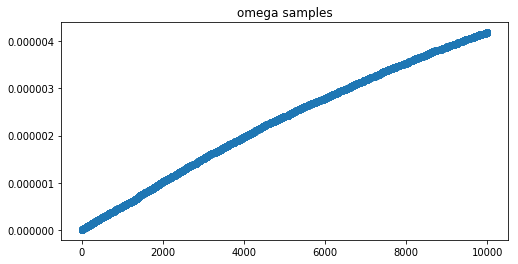

In [127]:
#scatterplot of each omega for all_thetas that were kept
plt.rcParams["figure.figsize"] = [8,4]
for i in range(0,all_thetas_of_all_thetas.shape[0]):
    
    plt.figure()
    plt.plot(all_thetas_of_all_thetas['All thetas'][i+1][:,0], 'o')
    plt.title("omega samples")

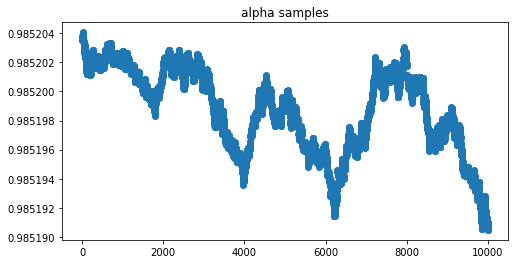

In [128]:
plt.rcParams["figure.figsize"] = [8,4]

for i in range(0,all_thetas_of_all_thetas.shape[0]):
    
    plt.figure()
    plt.plot(all_thetas_of_all_thetas['All thetas'][i+1][:,1], 'o')
    plt.title("alpha samples")

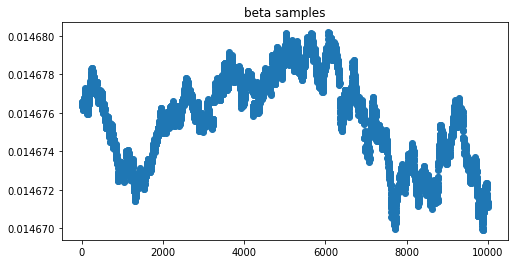

In [129]:

plt.rcParams["figure.figsize"] = [8,4]
for i in range(0,all_thetas_of_all_thetas.shape[0]):
    plt.figure()
    plt.plot(all_thetas_of_all_thetas['All thetas'][i+1][:,2], 'o')
    plt.title("beta samples")

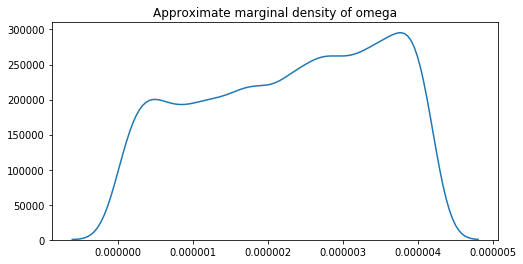

In [143]:
#omega density

plt.rcParams['figure.figsize'] = [8,4]
for i in range(0,all_thetas_of_all_thetas.shape[0]):
    
    plt.figure()
    sns.kdeplot(all_thetas_of_all_thetas['All thetas'][i+1][:,0])
    
    title='Approximate marginal density of omega'
    
    plt.title(title)
    plt.savefig(title+".png")
    

plt.show()

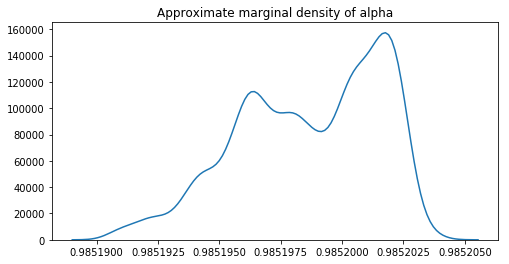

In [144]:
#alpha density

plt.rcParams['figure.figsize'] = [8,4]
for i in range(0,all_thetas_of_all_thetas.shape[0]):
    plt.figure()
    sns.kdeplot(all_thetas_of_all_thetas['All thetas'][i+1][:,1])
    
    title='Approximate marginal density of alpha'
    plt.title(title)
    plt.savefig(title+".png")

plt.show()

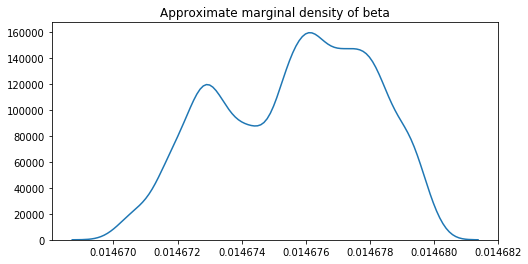

In [145]:
#Plot the density of the samples of each variable

plt.rcParams["figure.figsize"] = [8,4]
for i in range(0,all_thetas_of_all_thetas.shape[0]):
    
    plt.figure()
    sns.kdeplot(all_thetas_of_all_thetas['All thetas'][i+1][:,2])
    
    title='Approximate marginal density of beta'
    
    plt.title(title)
    plt.savefig(title+".png")

plt.show()

In [144]:
GARCH_param

,omega,alpha,beta,nu
Asset,,,,
Stock,0.0,0.985204,0.014677,49.515688


In [145]:
posterior_mean_computations

,means per sim batch,median per sim batch,avg omega value,avg alpha value,avg beta value,median omega value,median alpha value,median beta value
batch of nsims id,,,,,,,,
1,"[6e-06, 0.99934, 0.0384]","[7e-06, 0.999528, 0.040302]",6e-06,0.99934,0.0384,6e-06,0.99934,0.0384


Define the normalized residuals as:
$$\widehat{\epsilon_t}=\dfrac{y_t}{\widehat{h}_t^{1/2}}$$

In [104]:
#We would like to compute the normalized residuals define above
#Here we compute the conditional variance h_t valued at the mean of the posterior sample
h_mean_post_sample = h(posterior_mean_computations['avg omega value'][1],
                       posterior_mean_computations['avg alpha value'][1],
                      posterior_mean_computations['avg beta value'][1])

e_hat = np.empty(h_mean_post_sample.shape[0])

for obs in range(h_mean_post_sample.shape[0]):
        e_hat[obs] = logret[obs]/(h_mean_post_sample[obs]**0.5)
e_hat = e_hat.tolist()
e_hat = np.array(e_hat)

In [100]:
#important line otherwise the plots below would not show up
%matplotlib inline

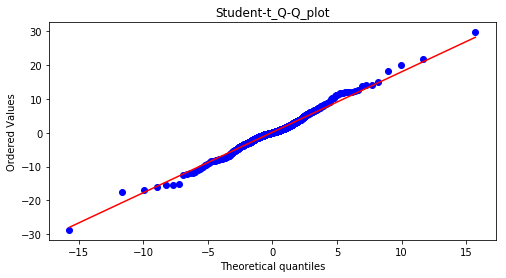

In [146]:
plt.rcParams['figure.figsize'] = [8,4]
stats.probplot(e_hat,sparams=3,dist="t", plot=plt)

title='Student-t_Q-Q_plot'

plt.title(title)
plt.savefig(title+".png")
plt.show()

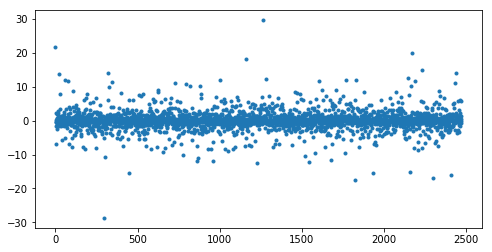

In [135]:
plt.rcParams['figure.figsize'] = [8,4]
plt.plot(e_hat,'.')
title='normalized_residuals_scatter_plot'
plt.savefig(title+".png")
plt.show()